# YouTube URL Analysis

## Preface
### Data descriptions

In [1]:
sample_size = 10000000 # specifies the sample size
limit = 15 # specifies the number of elements in lists and graphs

url_columns = ["id","hash","channelId","publishedAt","url","resolvedUrl","domain","resolved","dead","status_code"]
video_columns = ["id","hash","channelId","channelTitle","publishedAt","title","description","tags","categoryId","defaultLanguage","defaultAudioLanguage","duration","dimension","definition","caption","licensedContent","allowedIn","blockedIn","viewCount","likeCount","dislikeCount","favoriteCount","commentCount","requesttime"]
channel_columns = ["id","title","description","subscriberCount","videoCount","commentCount","viewCount","featuring","subscribing","country","publishedAt","daysactive","keywords","topics","wikitopics"]

### Import necessary modules

In [2]:


import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(14,8.27)})

### Load sample

In [3]:
# load and clean csv
pd_url_data = pd.read_csv('sample_' + str(sample_size) + '.csv')
pd_url_data.columns = url_columns

# add year column, based on publishedAt
pd_url_data['year'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.year

#todo handling missing data (e.g. resolvedURL not set, but not a shortener)

### clean domains

In [ ]:
# remove all www. or www2.
pd_url_data.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True) 

# replace all open.spotify.com by spotify.com
pd_url_data.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True) 

# todo: check domains and see whether more needs to be replaced

# Generic analysis

## Dead or alive (status codes)
When less than 5%, just leave it as is



In [5]:
# add count column
pd_url_data['count'] = 1 
# count URLs marked as dead on expansion and sort in reverse
pd_url_data_groupedDead = pd_url_data.groupby(["dead"]).count()['count'].sort_values(ascending=False) 
# count total number of URLs
total = pd_url_data_groupedDead[0] + pd_url_data_groupedDead[1] 
# calculate percentage
percent_dead = round(pd_url_data_groupedDead[1]/total*100,2) 
# print percentage
print("Total URLS: %s, of which %s (%s%%) dead" % (total,pd_url_data_groupedDead[1],percent_dead)) 

Total URLS: 9999999, of which 352942 (3.53%) dead


## Basic stats (based on video's, not channels)
### Top domains

In [6]:
# reset count column
pd_url_data['count'] = 1 
# count domains in URLs data set and sort in reverse
pd_url_data_groupedDomain = pd_url_data.groupby(["domain"]).count()['count'].sort_values(ascending=False) 
# print header
print("Top %s domains" % (limit)) 
# print most used domains overall
print(pd_url_data_groupedDomain.head(limit)) 

Top 15 domains
domain
youtube.com            3186596
facebook.com           1141732
twitter.com             914616
instagram.com           541257
google.com              209012
twitch.tv                99016
vk.com                   94412
play.google.com          54171
soundcloud.com           54072
amazon.com               48427
accounts.google.com      44242
itunes.apple.com         42911
pinterest.com            41105
patreon.com              37989
amazon.de                27620
Name: count, dtype: int64


### Top deep links

In [7]:
# reset count column
pd_url_data['count'] = 1 
# count resolved deep links in URLs data set and sort in reverse
pd_url_data_groupedUrl = pd_url_data.groupby(["resolvedUrl"]).count()['count'].sort_values(ascending=False) 
# print header
print("Top %s resolvedUrl" % (limit)) 
# print most used deep links
print(pd_url_data_groupedUrl.head(limit)) 

Top 15 resolvedUrl
resolvedUrl
https://unacademy.com/unavailable                        8474
https://www.youtube.com/error?src=404                    8008
https://www.youtube.com/user/euronewsnetwork/channels    7292
https://www.facebook.com/euronews                        6826
http://incompetech.com/                                  6369
https://www.zee5.com/                                    6106
https://creativecommons.org/licenses/by/4.0/)            6002
https://www.zee5.com                                     5554
https://www.youtube.com/playlist?list...                 5532
https://www.instagram.com/zee5                           5316
https://twitter.com/ZEE5India                            5255
https://www.facebook.com/ZEE5/                           5187
http://creativecommons.org/licenses/by/3.0/              4714
https://onlinedatinglogic.com/forums/forum/qa/           4492
https://datinglogic.net/forums/forum/qa/                 4390
Name: count, dtype: int64


### Top TLDs

In [8]:
# reset count column
pd_url_data['count'] = 1 
# make TLD column based on domain
pd_url_data['tld'] = pd_url_data['domain'].str.replace('^.*\.', '', regex=True) 
# count TLDs used and sort in reverse
pd_url_data_groupedTld = pd_url_data.groupby(["tld"]).count()['count'].sort_values(ascending=False)
# print header
print("Top %s TLDs" % (limit))
# print most used TLDs
print(pd_url_data_groupedTld.head(limit))

Top 15 TLDs
tld
com    7519304
tv      169695
net      65931
in       49513
de       49229
org      48469
me       40379
ru       37494
br       29964
kr       29784
gg       27788
co       23505
jp       21136
st       19634
uk       16810
Name: count, dtype: int64


# Monetization

## Allowed merch and monetization on Github (by Bernhard)

In [9]:
# import merch and crowd lists
from allowed_3rdparty import merch, crowd

# drop previously added count column
if 'count' in pd_url_data.columns:
    pd_url_data = pd_url_data.drop(['count'],axis=1)

# add boolean column to pd_url_data based on presence in lists
pd_url_data["crowd"] = np.where(pd_url_data["domain"].isin(crowd), True, False)
pd_url_data["merch"] = np.where(pd_url_data["domain"].isin(merch), True, False)

## Percentage of videos that have at least one merchandise or one crowd-funding link.

In [11]:
# make a column where at least one of monetized or crowd is true
monetized = pd_url_data['merch'] | pd_url_data['crowd'] 
pd_url_data['monetized'] = monetized
# get number of video ids where monetized = True
monetized_video_number = len(pd_url_data[pd_url_data['monetized']==True])
total_video_number = len(pd_url_data['monetized'])
percent_video_monetized = round(monetized_video_number/total_video_number*100,2)

print("%s videos are monetized out of %s total videos, that is %s%%" % (monetized_video_number,total_video_number,percent_video_monetized))

202986 videos are monetized out of 9999999 total videos, that is 2.03%


## Number of YouTube videos per domain, per monetization type. As well as graph of domains per year, per monetization type


crowd domain count
domain
patreon.com            37989
streamlabs.com         11495
apoia.se                1677
gofundme.com            1278
tipeee.com               858
patronite.pl             692
kickstarter.com          395
change.org               341
indiegogo.com            286
vakinha.com.br           154
catarse.me               127
justgiving.com            84
milaap.org                63
forhumanpeoples.com       54
camp-fire.jp              35
Name: count, dtype: int64


crowd domain stats
count       39.000000
mean      1428.256410
std       6286.607242
min          1.000000
25%          2.500000
50%         15.000000
75%        140.500000
max      37989.000000
Name: count, dtype: float64


merch domain count
domain
soundcloud.com            54072
itunes.apple.com          42911
teespring.com              9242
spreadshirt.com            8996
store.steampowered.com     6507
bandcamp.com               5143
etsy.com                   2024
store.line.me              1741
bigc

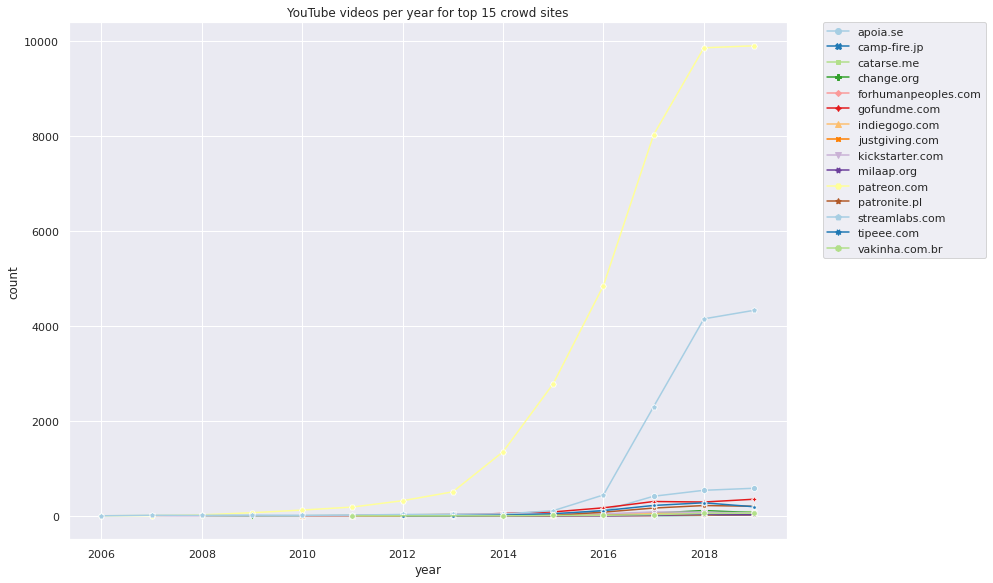

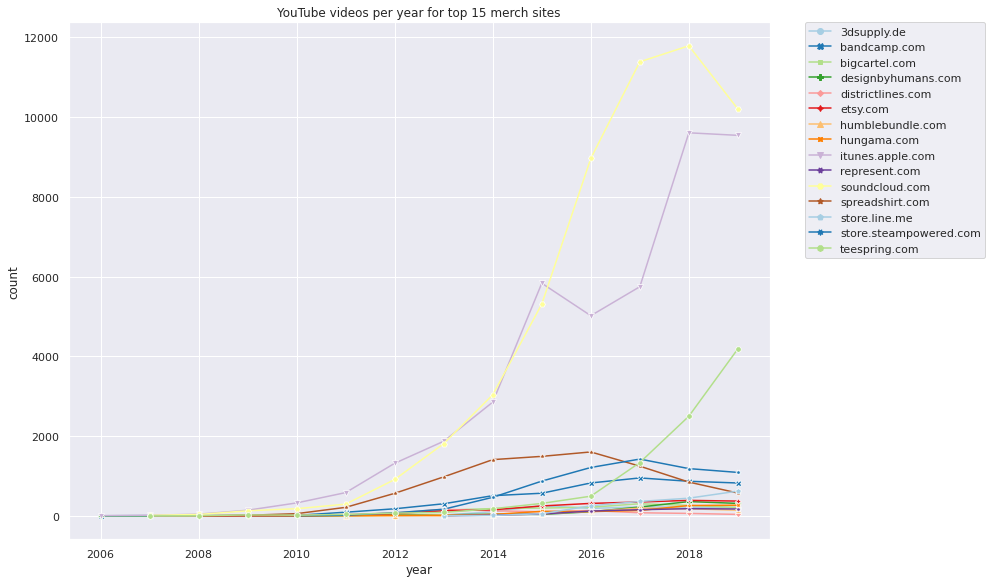

In [10]:
for type in ['crowd','merch']:

    ''' Count and describe '''

    # reset count column to 1
    pd_url_data['count'] = 1
    # filter pd_url_data to only retain info for rows with merch domain
    filtered = {}
    filtered[type] = pd_url_data[pd_url_data[type]==True]
    # count type domains in data set and sort in reverse
    filtered_count = {}
    filtered_count[type] = filtered[type].groupby(["domain"]).count()['count'].sort_values(ascending=False)
    # print header
    print("%s domain count" % type)
    # print most used merch domains
    print(filtered_count[type].head(limit))
    print("\n")
    # print merch domain stats
    print("%s domain stats" % type)
    print(filtered_count[type].describe())
    print("\n")

    ''' Graph '''

    # limit data by top overall merch domain for graph
    top_domains = {}
    top_domains[type] = filtered_count[type].keys().to_series().head(limit)
    filtered_limited = {}
    filtered_limited[type] = filtered[type][filtered[type]['domain'].isin(top_domains[type])==True]

    # get number of unique domains for color palette in graph 
    num_domains = {}
    num_domains[type] = len(filtered_limited[type]['domain'].unique())
    color_palette = {}
    color_palette[type] = sns.color_palette("Paired",n_colors=num_domains[type])

    # count by merch domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"]).count()

    # plot rise of crowd sites, per year
    plt.figure()
    sns.lineplot(x="year", y="count", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube videos per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


## Todo

Channel data set
* Fuse this with channels data set. Finding a way to use the URLs to characterize channels.
   * Merch and monetization per channel. When did they introduce this?
   * Whether channels changed merch or crowd-financing, giving that they not backport.
* Via topic and/or video categories. E.g. gaming may have a very different URL profile then news/politics. 
* Merch stores with particular topical affinity (e.g. alt-right channels use store X) - alternative ways of classifying youtube. Otherway around: categories that are more suited to crowd-funding than others.

Alternative modes of classification? 
* For a channel we have channel description, keywords, all video titles and keywords. Run as a topic model.
* Video categories are unique and chosen by uploaders
* Channel category column can have several channels, is assigned done automatically by YouTube
* (channels have keywords too, which are much more descriptive. But long-tail, language specific)


Other
* Patreon pledgers, crowd-funding sites/pledges.
* Collect ASINs. How many different products are being advertised (most popular producst - # videos, #views; youtube as amazon catalogue).
* Each URL may afford something for analysis.
* Cross-language analysis. (Videos have language, channels have country flag). 

# Random

In [12]:
# domains used per channelId
pd_url_data['count'] = 1
pd_url_data_grouped = pd_url_data.groupby(["channelId","domain"]).count()['count'].sort_values(ascending=False)
pd_url_data_grouped.head()

channelId                 domain     
UC_IEcnNeHc_bwd92Ber-lew  youtube.com    25612
UC1pHFqCMAIHP8gr4lYGtNLA  youtube.com    20448
UCP0uG-mcMImgKnJz-VjJZmQ  youtube.com    18739
UCIme7og-uTpdRXRgm0zzA2A  youtube.com    17521
UCFjzJYgxHjk44AFoEwwgPjg  youtube.com    17365
Name: count, dtype: int64